# Comparison with medial-axis method

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point, GeometryCollection, MultiLineString 
from shapely.plotting import plot_line, plot_points, plot_polygon
import numpy as np
from matplotlib import image

In [2]:
class medialAxisDungeonMaps:
    
    #Global Variables 
    # mapInPolygons(dir)
        
    
    #Constructor
    #------------------------------------------------------------------------------------------------------------------------
    def __init__(self, dir):
        self.dir = dir
        self.polygonMap = self.mapInPolygons(self.dir)
        self.x = self.samplingFreeWorkSpace(self.polygonMap)
    #------------------------------------------------------------------------------------------------------------------------
    #Methods
    #------------------------------------------------------------------------------------------------------------------------
    def mapInPolygons(self, dir):
        retraive_polygon=np.load(self.dir, allow_pickle=True)
        
        # Swap coordinates
        inverse_retraive_polygon=[]
        for p in retraive_polygon:
            polygon_x=[]
            for pp in p:
                polygon_x.append((pp[1],pp[0]))
            inverse_retraive_polygon.append(polygon_x)
        
        holes = len(inverse_retraive_polygon)-1
        if holes == 0:
            polygonMap = Polygon(inverse_retraive_polygon[0]) 
        elif holes == 1:
            polygonMap = Polygon(inverse_retraive_polygon[0],
                             [inverse_retraive_polygon[1]]) 
        elif holes == 2:
            polygonMap = Polygon(inverse_retraive_polygon[0],
                             [inverse_retraive_polygon[1],inverse_retraive_polygon[2]]) 
        elif holes == 3:
            polygonMap = Polygon(inverse_retraive_polygon[0],
                             [inverse_retraive_polygon[1],inverse_retraive_polygon[2],inverse_retraive_polygon[3]]) 
        elif holes == 4:
            polygonMap = Polygon(inverse_retraive_polygon[0],
                             [inverse_retraive_polygon[1],inverse_retraive_polygon[2],inverse_retraive_polygon[3],
                              inverse_retraive_polygon[4]]) 
        elif holes == 5:
            polygonMap = Polygon(inverse_retraive_polygon[0],
                             [inverse_retraive_polygon[1],inverse_retraive_polygon[2],inverse_retraive_polygon[3],
                              inverse_retraive_polygon[4],inverse_retraive_polygon[5]]) 
        else:
            print('ERROR: many polygons')
        return polygonMap
        
    #------------------------------------------------------------------------------------------------------------------------
    def samplingFreeWorkSpace(self, polygonMap):
        '''sampling random point in free workspace'''
        # x = np.array((np.random.randint(0,64,size=None, dtype=np.uint8),np.random.randint(0,64,size=None, dtype=np.uint8)))
        x = np.array((np.random.rand()*64,np.random.rand()*64))
        x = Point(x)
        while(self.polygonMap.contains(Point(x)))==False:
            # x = np.array((np.random.randint(0,64,size=None, dtype=np.uint8),np.random.randint(0,64,size=None, dtype=np.uint8)))
            x = np.array((np.random.rand()*64,np.random.rand()*64))
            x = Point(x)
        return x
        
    #------------------------------------------------------------------------------------------------------------------------
    def __MyFunctionContains(self, point, line):
        '''my function to determine if a point is in a line segment'''
        if point.x >= line.xy[0][0] and point.x <= line.xy[0][1]: # right slope
            return True
        elif point.x < line.xy[0][0] and point.x > line.xy[0][1]: #left slope
            return True
        else:
            return False
            
    #------------------------------------------------------------------------------------------------------------------------
    def __findLimits(self, A, p, q):
        '''find a border limit'''
    
        # To found line equation y=m(x-x1)+y1 between p and q
        if (p.x == q.x): #vertical line
            # print('m <-- inf')
            m = np.inf
        else:
            m = (p.y-q.y)/(p.x-q.x)
        
        #direction q to p
        b = p.y-m*p.x #y=mx+b
        
        # To found the upper bisection limit
        if m < np.inf: #HORIZONTAL
            if p.x > q.x: #right
                # print('direction q to p: right')
                LS = LineString([[q.x, m*q.x+b],[64, m*64+b]]) # a line from q to map limit
                ul = self.__indexGeometry(p, LS, A, 'right')
        
            elif p.x < q.x: #left
                # print('direction q to p: left')
                LS = LineString([[0, m*0+b],[q.x, m*q.x+b]])
                ul = self.__indexGeometry(p, LS, A, 'left')
    
        else: #VERTICAL
            if p.y > q.y: #top
                # print('direction q to p: top')
                LS = LineString([[q.x, q.y],[q.x, 64]])
                ul = self.__indexGeometry(p, LS, A, 'top')
    
            elif p.y < q.y: #bottom
                # print('direction q to p: bottom')
                LS = LineString([[q.x, 0],[q.x, q.y]])
                ul = self.__indexGeometry(p, LS, A, 'bottom')
    
        LS = LineString([q, ul])
        return LS, ul
        
    #------------------------------------------------------------------------------------------------------------------------
    def __indexGeometry(self, p, LS, A, dir):
        '''this function only is used to retorn a x,y point 
        from the diferets data structures of the librery shapely geometry'''
        
        if LS.intersects(A):
            ul = LS.intersection(A)
            gt = LS.intersection(A).geom_type
            # print('intersection with map boundaries : ', ul, ' Type: ',gt)

            if gt == 'GeometryCollection':        
                alist = []
                for i in ul.geoms:
                    if i.geom_type != "Point":
                        alist.append(i)
                ul = MultiLineString(alist)
                gt = 'MultiLineString'

            if gt == 'MultiLineString':
                if dir == 'bottom':
                    i = 0
                    while ul.geoms[i].contains(p) == False:
                        i+=1
                    ul = Point(ul.geoms[i].xy[0][0], ul.geoms[i].xy[1][0])     
                    
                elif dir == 'top':
                    i = 0
                    while ul.geoms[i].contains(p) == False:
                        i+=1
                    ul = Point(ul.geoms[i].xy[0][1], ul.geoms[i].xy[1][1])
                    
                elif dir == 'right': #*error
                    i = 0
                    while self.__MyFunctionContains(p,ul.geoms[i]) == False:
                        i+=1
                    ul = Point(ul.geoms[i].xy[0][1], ul.geoms[i].xy[1][1])     
                    
                elif dir == 'left':
                    i = 0
                    while self.__MyFunctionContains(p,ul.geoms[i]) == False:
                        i+=1
                    ul = Point(ul.geoms[i].xy[0][0], ul.geoms[i].xy[1][0])     
                    
            elif gt == 'LineString':
                if dir == 'bottom':
                    ul = Point(ul.xy[0][0], ul.xy[1][0])
                    
                elif dir == 'top':
                    ul = Point(ul.xy[0][1], ul.xy[1][1])
                    
                elif dir == 'right':
                    ul = Point(ul.xy[0][1], ul.xy[1][1])
                    
                elif dir == 'left':
                    ul = Point(ul.xy[0][0], ul.xy[1][0])
            else:
                print('update to add data structure', gt)
        # print('s: ', ul) #s or ul it is the same
        return ul

    #------------------------------------------------------------------------------------------------------------------------
    def __validation(self, multiPoint):
        i = 0
        contactPoints = []
        averagePoints = []
        toClose = []
        while i < len(multiPoint):
            contactPoints.append(multiPoint[i].representative_point())
            # print(multiPoint[i], '<-->' ,
            #       multiPoint[i].representative_point())
            i+=1
        # print('conatact points', contactPoints)
        i=1
        for j in contactPoints:
            if i > 1:
                # print('distance: ', j.distance(j_ant))
                if j.distance(j_ant) < 1.0:
                    # print('To close')
                    toClose.append(True)
                    averagePoints.append(Point((j_ant.x+j.x)/2,(j_ant.y+j.y)/2))
                    # break 
                else:
                    toClose.append(False)
            j_ant = j
            i+=1
        return toClose, averagePoints    
    #------------------------------------------------------------------------------------------------------------------------
    def medialAxis2D(self, A, p):
        '''return a point that is part of the medial axis \n
        p:center of the disc\n
        q:disc contact point\n
        s:line(pq) limit point'''
    
        #Outputs------------------------------------------------------
        # list_p = []
        # list_B = []
        #PARAMETERS---------------------------------------------------
        # r = 1.0 #radio
        step_r = 0.01#0.01 #step to increment radio
        attempts = 10000 #max number of iteration to reach a point q
        attempts_2 = 500 #maximo number of cycles until found the MA
        resolution = 32 # circunference resolution 
        #-------------------------------------------------------------
    
        q = Point() #* (is really necessary?)
        s = Point() #*
        medialAxisFound = False
        counter_2 = 0
    
        while medialAxisFound == False and counter_2 <= attempts_2:
    
            #-------------------------------------------------------------
            # print('----------------------------------------------------\n\r'
            #       ,'move: ',counter_2, ' | ', '\n\rp: ', p)
            #-------------------------------------------------------------
            # list_p.append(p)
            r = 1.0
            B = p.buffer(r, resolution)  
            count = 1 #attempts to try to touch a q point
            counter_2 += 1
            
            while (A.contains(B)==True and A.boundary.touches(B)==False and count<=attempts):
                count += 1
                r += step_r
                B = p.buffer(r, resolution)
            
            if count < attempts:
    
                # list_B.append(B)
                if A.boundary.intersection(B).geom_type=='MultiPoint': #END 
                    # print('MultiPoint')
                    medialAxisFound = True
                    
                elif A.boundary.intersection(B).geom_type=='Point': #SINGLE contact point
                    q = Point(np.array([A.boundary.intersection(B).x, A.boundary.intersection(B).y]))
                    # print('q: ', q, 'Point')
                    if p != q:
                        if counter_2 == 1 or (counter_2 > 1 and line_ps.contains(q) == False):
                            line_ps, s = self.__findLimits(A, p, q)
                        else: #q is not collinear to s
                            s = p_memory
                            line_ps = LineString([p, s])
                        p_memory = p    
                        p = line_ps.centroid
                    else:
                        print('invalid point')
                        break
        
                elif A.boundary.intersection(B).geom_type=='LineString': #SINGLE contact point
                    q = Point(np.array([(A.boundary.intersection(B).xy[0][0] + A.boundary.intersection(B).xy[0][1])/2, 
                                 (A.boundary.intersection(B).xy[1][0]+A.boundary.intersection(B).xy[1][1])/2 ], 
                                 dtype=np.float64)) #x1.x#x0.x/2, x0.y+x1.y/2
                    # print('q: ', q, 'LineString')
                    if p != q:
                        if counter_2 == 1 or (counter_2 > 1 and line_ps.contains(q) == False):
                            line_ps, s = self.__findLimits(A, p, q)
                        else: 
                            s = p_memory
                            line_ps = LineString([p, s])
                        p_memory = p    
                        p = line_ps.centroid
                    else:
                        print('invalid point')
                        break
                
                elif A.boundary.intersection(B).geom_type=='MultiLineString': #END (check grid_size=None)
                    # print(A.boundary.intersection(B), 'MultiLineString')
                    averagePoints = []
                    is_toClose, averagePoints = self.__validation(A.boundary.intersection(B).geoms)
                    # print('is to close?: ', is_toClose, '. AP: ', averagePoints)
                    necessary_newPoint = True
                    for e in is_toClose:
                        if e == False:
                            necessary_newPoint = False
                            break
                    if necessary_newPoint == True:
                        q = averagePoints[0] #only to multiLineString with two elements
                        if p != q:
                            if counter_2 == 1 or (counter_2 > 1 and line_ps.contains(q) == False):
                                line_ps, s = self.__findLimits(A, p, q)
                            else: 
                                s = p_memory
                                line_ps = LineString([p, s])
                            p_memory = p    
                            p = line_ps.centroid
                        else:
                            print('invalid point')
                            break
                    else:
                        # print('q: ', q, 'MultiLineString')
                        medialAxisFound = True
                        
                else:
                    print(A.boundary.intersection(B).geom_type, '(maybe geometric collection) Re-sampling.')
                    p = self.samplingFreeWorkSpace(A)
                    counter_2 = 0
                    count = attempts + 1
                    print('p: ', p)
            else:
                print('Invalid disc in ', count, ' attempts')
                p = None
                B = None
                break
                # medialAxisFound = True
        
        return medialAxisFound, p 

In [16]:
map = 77
MASamples = 100
dir = 'polygons/polygon_m'+str(map)+'.npy'
list_x = []
list_ma = []
test_ma = medialAxisDungeonMaps(dir)
A = test_ma.polygonMap
k = 1
while k<=MASamples:
    x = test_ma.samplingFreeWorkSpace(A)
    print(k, '| x: ', x)
    MA_found, p = test_ma.medialAxis2D(A,x)
    print('              MA: ',MA_found, '  | p: ', p)
    if MA_found == True:
        list_x.append(x)
        list_ma.append(p)
        k+=1


1 | x:  POINT (7.157760951327717 20.890449996106582)
              MA:  True   | p:  POINT (8.5 11)
2 | x:  POINT (53.54250236274025 41.66896279459701)
              MA:  True   | p:  POINT (37.883867604784214 41.5)
3 | x:  POINT (13.800356401322176 39.19600465483042)
              MA:  True   | p:  POINT (13.800356401322176 37.5)
4 | x:  POINT (0.8599413953121982 21.312732299679418)
              MA:  True   | p:  POINT (8.5 11)
5 | x:  POINT (15.607402991871268 15.862733416710938)
              MA:  True   | p:  POINT (8.5 11)
6 | x:  POINT (42.96732561855928 41.28879812474945)
              MA:  True   | p:  POINT (42.96732561855928 41)
7 | x:  POINT (41.884303785583086 47.9674490030264)
              MA:  True   | p:  POINT (37.916530720036484 41.5)
8 | x:  POINT (14.34828816902818 39.67313884305823)
              MA:  True   | p:  POINT (14.348288169028182 37.5)
9 | x:  POINT (3.1488920021250024 8.397173090310105)
              MA:  True   | p:  POINT (8.5 9.120480919597167)
10 | 

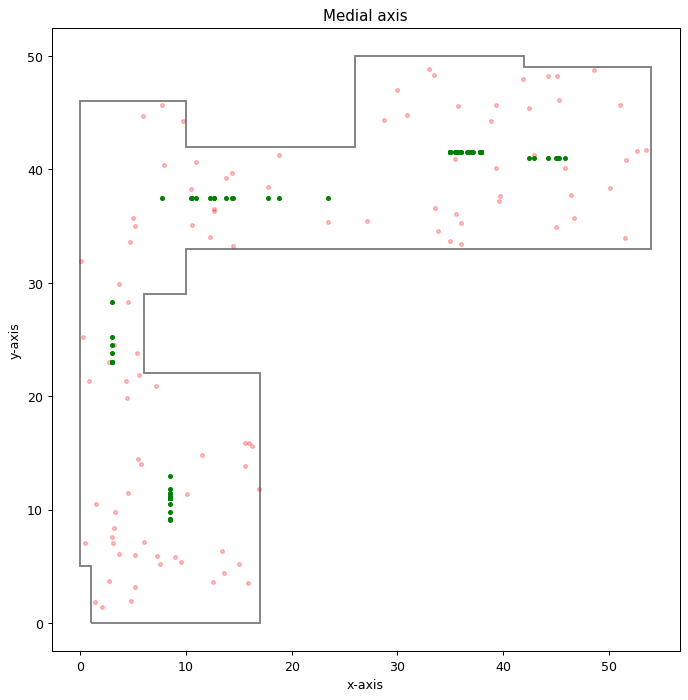

In [17]:
#--------------------------------------------------------
#                PLOT
#--------------------------------------------------------
fig = plt.figure(1, figsize=(9,9), dpi=90)
#map
ax = fig.add_subplot(1,1,1)
plot_polygon(A, ax=ax, add_points=False, facecolor='white',linewidth=1.5,color='gray')
for i in list_x:
    plot_points(i, ax=ax, marker='.', color='red', label = 'x', alpha = 0.25, )
for i in list_ma:
    plot_points(i, ax=ax, marker='.', color='green', label = 'MA(x)')

plt.title('Medial axis')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()
#--------------------------------------------------------

In [18]:
arr_ma = np.array(list_ma)
np.save('numpy_MA_with_ShapelyGeometry/medial_axis_map'+str(map)+'_smp.npy', arr_ma)
